# Optimal Compression Level Prediction

This notebook trains an XGBoost regressor to predict the optimal compression level based on `num_users` and `avg_cqi` inputs.

**Optimal Compression**: The compression level that gives the best QoE (lowest possible MSE while maintaining ≥99% delay_reliability).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('compression_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(10)

Dataset shape: (1249, 11)

Columns: ['run_id', 'num_users', 'user_id', 'compression_level', 'total_frames', 'on_time_frames', 'avg_delay_ms', 'delay_reliability', 'user_satisfied', 'avg_mse', 'avg_cqi']


,run_id,num_users,user_id,compression_level,total_frames,on_time_frames,avg_delay_ms,delay_reliability,user_satisfied,avg_mse,avg_cqi
0,1,2,0,20,1074,1043,2.38815,0.971136,0,296.858,14.5282
1,1,2,1,5,1074,995,2.50806,0.926443,0,827.243,14.3510
2,2,2,0,45,1074,990,4.89038,0.921788,0,171.913,14.5069
3,2,2,1,40,1074,811,6.80084,0.755121,0,336.056,14.3179
4,3,2,0,40,1074,1003,4.56798,0.933892,0,178.918,14.6168
5,3,2,1,25,1074,932,3.62746,0.867784,0,320.687,14.2149
6,4,2,0,20,1074,1042,2.39181,0.970205,0,297.829,14.5653
7,4,2,1,15,1074,959,2.64679,0.892924,0,428.637,14.4916
8,5,2,0,70,1074,1003,4.35753,0.933892,0,108.947,14.5257
9,5,2,1,10,1074,961,2.63143,0.894786,0,554.933,14.3679


In [3]:
# Basic statistics
df.describe()

,run_id,num_users,user_id,compression_level,total_frames,on_time_frames,avg_delay_ms,delay_reliability,user_satisfied,avg_mse,avg_cqi
count,1249.000000,1249.000000,1249.000000,1249.000000,1249.0,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000
mean,176.306645,5.016013,2.008006,42.241793,1074.0,851.469175,5.668847,0.792802,0.008807,373.357187,14.139683
std,79.400052,1.563732,1.682279,22.721893,0.0,145.504524,2.455075,0.135479,0.093469,154.638676,0.258687
min,1.000000,2.000000,0.000000,5.000000,1074.0,365.000000,2.270200,0.339851,0.000000,81.643200,13.461000
25%,116.000000,4.000000,1.000000,20.000000,1074.0,751.000000,3.689180,0.699255,0.000000,274.987000,13.957000
50%,186.000000,5.000000,2.000000,40.000000,1074.0,877.000000,5.760650,0.816574,0.000000,360.553000,14.052800
75%,243.000000,6.000000,3.000000,60.000000,1074.0,969.000000,7.030730,0.902235,0.000000,435.848000,14.347700
max,300.000000,7.000000,6.000000,80.000000,1074.0,1074.000000,23.230900,1.000000,1.000000,839.395000,14.964300


In [4]:
# Available compression levels
COMPRESSION_LEVELS = sorted(df['compression_level'].unique())
print(f"Compression levels: {COMPRESSION_LEVELS}")
print(f"Number of unique compression levels: {len(COMPRESSION_LEVELS)}")

Compression levels: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80)]
Number of unique compression levels: 16


## 2. Calculate Optimal Compression Level

For each unique scenario (defined by `run_id`, `num_users`), we find the compression level that:
1. **First**: Satisfies delay_reliability ≥ 99%
2. **Then**: Minimizes avg_mse among those satisfying the constraint

If no compression level meets reliability, we pick the one with highest reliability (fallback).

In [5]:
def find_optimal_compression(group):
    """
    Find optimal compression for a given (run_id, num_users) scenario.
    Returns the compression level with lowest MSE among those with >=99% reliability.
    Falls back to highest reliability if none meet threshold.
    """
    RELIABILITY_THRESHOLD = 0.99
    
    # Filter rows meeting reliability constraint
    reliable = group[group['delay_reliability'] >= RELIABILITY_THRESHOLD]
    
    if len(reliable) > 0:
        # Pick the one with minimum MSE
        best_row = reliable.loc[reliable['avg_mse'].idxmin()]
    else:
        # Fallback: pick highest reliability
        best_row = group.loc[group['delay_reliability'].idxmax()]
    
    return best_row['compression_level']

# Group by scenario and compute optimal compression
# Each user in a scenario may have different CQI, so we aggregate per user
optimal_per_row = []

# For each run, all users experience similar network conditions
# We compute optimal compression per (run_id, compression_level) aggregated metrics
# But since we predict per-user, we need to map based on run context

# Simpler approach: for each (run_id), find which compression level gives best QoE
# considering all users' average performance

run_optimal = df.groupby(['run_id', 'compression_level']).agg({
    'num_users': 'first',
    'delay_reliability': 'mean',  # Average reliability across users
    'avg_mse': 'mean',             # Average MSE across users
    'avg_cqi': 'mean'              # Average CQI across users
}).reset_index()

print(f"Aggregated scenarios: {len(run_optimal)}")
run_optimal.head(10)

Aggregated scenarios: 1109


,run_id,compression_level,num_users,delay_reliability,avg_mse,avg_cqi
0,1,5,2,0.926443,827.243,14.3510
1,1,20,2,0.971136,296.858,14.5282
2,2,40,2,0.755121,336.056,14.3179
3,2,45,2,0.921788,171.913,14.5069
4,3,25,2,0.867784,320.687,14.2149
5,3,40,2,0.933892,178.918,14.6168
6,4,15,2,0.892924,428.637,14.4916
7,4,20,2,0.970205,297.829,14.5653
8,5,10,2,0.894786,554.933,14.3679
9,5,70,2,0.933892,108.947,14.5257


In [6]:
# Find optimal compression per run
optimal_map = {}

for run_id in run_optimal['run_id'].unique():
    run_data = run_optimal[run_optimal['run_id'] == run_id]
    optimal_comp = find_optimal_compression(run_data)
    optimal_map[run_id] = optimal_comp

print(f"Optimal compression computed for {len(optimal_map)} runs")
print(f"\nSample mappings: {dict(list(optimal_map.items())[:10])}")

Optimal compression computed for 285 runs

Sample mappings: {np.int64(1): np.float64(20.0), np.int64(2): np.float64(45.0), np.int64(3): np.float64(40.0), np.int64(4): np.float64(20.0), np.int64(5): np.float64(70.0), np.int64(6): np.float64(5.0), np.int64(7): np.float64(35.0), np.int64(8): np.float64(5.0), np.int64(9): np.float64(70.0), np.int64(10): np.float64(75.0)}


In [7]:
# Create training dataset with unique (run_id) -> (num_users, avg_cqi) -> optimal_compression
training_data = run_optimal.groupby('run_id').agg({
    'num_users': 'first',
    'avg_cqi': 'mean'  # Average CQI for this run
}).reset_index()

# Add optimal compression as target
training_data['optimal_compression'] = training_data['run_id'].map(optimal_map)

print(f"Training dataset shape: {training_data.shape}")
training_data.head(10)

Training dataset shape: (285, 4)


,run_id,num_users,avg_cqi,optimal_compression
0,1,2,14.43960,20.0
1,2,2,14.41240,45.0
2,3,2,14.41585,40.0
3,4,2,14.52845,20.0
4,5,2,14.44680,70.0
5,6,2,14.43520,5.0
6,7,2,14.44245,35.0
7,8,2,14.45730,5.0
8,9,2,14.43870,70.0
9,10,2,14.25365,75.0


Optimal compression distribution:
optimal_compression
5.0     34
10.0    35
15.0    34
20.0    32
25.0    23
30.0    12
35.0    18
40.0    25
45.0    14
50.0    11
55.0     8
60.0     6
65.0    12
70.0    11
75.0     7
80.0     3
Name: count, dtype: int64


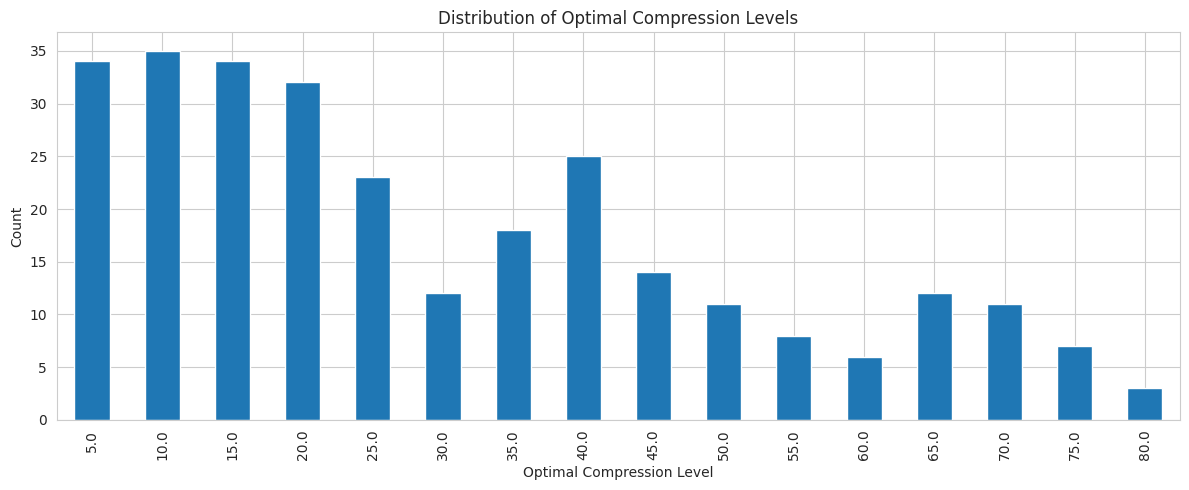

In [8]:
# Check target distribution
print("Optimal compression distribution:")
print(training_data['optimal_compression'].value_counts().sort_index())

fig, ax = plt.subplots(figsize=(12, 5))
training_data['optimal_compression'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Optimal Compression Level')
ax.set_ylabel('Count')
ax.set_title('Distribution of Optimal Compression Levels')
plt.tight_layout()
plt.show()

## 3. Feature Engineering & Preparation

In [9]:
# Features: num_users, avg_cqi (as per user requirements)
# Avoiding directly correlated or derived columns like delay, MSE, reliability

FEATURES = ['num_users', 'avg_cqi']
TARGET = 'optimal_compression'

X = training_data[FEATURES].copy()
y = training_data[TARGET].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures:\n{X.describe()}")

Features shape: (285, 2)
Target shape: (285,)

Features:
        num_users     avg_cqi
count  285.000000  285.000000
mean     4.382456   14.178060
std      1.669225    0.126673
min      2.000000   13.979483
25%      3.000000   14.093650
50%      4.000000   14.139990
75%      6.000000   14.219812
max      7.000000   14.534850


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 228 samples
Test set: 57 samples


## 4. Train XGBoost Regressor

In [11]:
# XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train
model.fit(X_train, y_train)
print("Model trained successfully!")

Model trained successfully!


In [12]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

Cross-validation MAE: 16.67 (+/- 3.83)


## 5. Model Evaluation

In [13]:
def snap_to_compression_level(pred):
    """
    Snap regression output to nearest valid compression level.
    Valid levels: 5, 10, 15, 20, ..., 80
    """
    valid_levels = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
    idx = np.abs(valid_levels - pred).argmin()
    return valid_levels[idx]

# Predictions
y_pred_raw = model.predict(X_test)
y_pred_snapped = np.array([snap_to_compression_level(p) for p in y_pred_raw])

print(f"Sample raw predictions: {y_pred_raw[:10].round(2)}")
print(f"Sample snapped predictions: {y_pred_snapped[:10]}")
print(f"Actual values: {y_test.values[:10]}")

Sample raw predictions: [35.52 15.19 25.99 15.85 50.78 19.41 16.83 37.   36.56 20.56]
Sample snapped predictions: [35 15 25 15 50 20 15 35 35 20]
Actual values: [75. 20.  5. 20. 20. 40. 40. 55. 40. 15.]


In [14]:
# Evaluation metrics
mae_raw = mean_absolute_error(y_test, y_pred_raw)
mae_snapped = mean_absolute_error(y_test, y_pred_snapped)
rmse_raw = np.sqrt(mean_squared_error(y_test, y_pred_raw))
rmse_snapped = np.sqrt(mean_squared_error(y_test, y_pred_snapped))
r2 = r2_score(y_test, y_pred_snapped)

# Exact match accuracy
exact_match = (y_pred_snapped == y_test.values).mean() * 100
# Within 1 level (±5)
within_1 = (np.abs(y_pred_snapped - y_test.values) <= 5).mean() * 100
# Within 2 levels (±10)
within_2 = (np.abs(y_pred_snapped - y_test.values) <= 10).mean() * 100

print("=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"MAE (raw):     {mae_raw:.2f}")
print(f"MAE (snapped): {mae_snapped:.2f}")
print(f"RMSE (raw):    {rmse_raw:.2f}")
print(f"RMSE (snapped):{rmse_snapped:.2f}")
print(f"R² Score:      {r2:.4f}")
print(f"\nClassification-like Metrics:")
print(f"Exact Match:   {exact_match:.1f}%")
print(f"Within ±5:     {within_1:.1f}%")
print(f"Within ±10:    {within_2:.1f}%")
print("=" * 50)

MODEL EVALUATION RESULTS
MAE (raw):     15.36
MAE (snapped): 15.35
RMSE (raw):    19.74
RMSE (snapped):19.75
R² Score:      -0.3847

Classification-like Metrics:
Exact Match:   7.0%
Within ±5:     38.6%
Within ±10:    52.6%


Feature Importance:
     Feature  Importance
0  num_users    0.676618
1    avg_cqi    0.323383


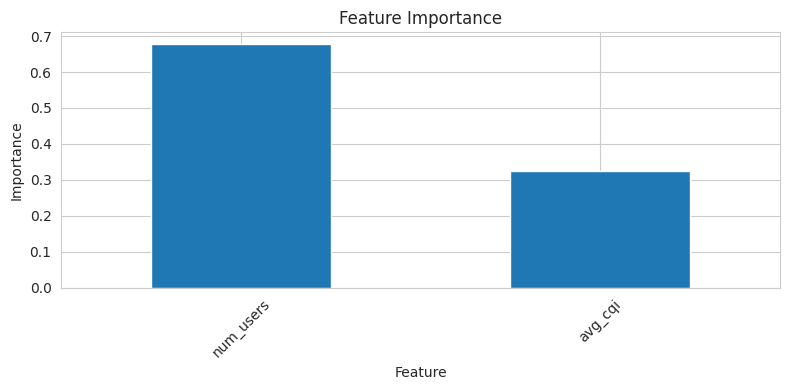

In [15]:
# Feature importance
importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance)

fig, ax = plt.subplots(figsize=(8, 4))
importance.plot(kind='bar', x='Feature', y='Importance', ax=ax, legend=False)
ax.set_ylabel('Importance')
ax.set_title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

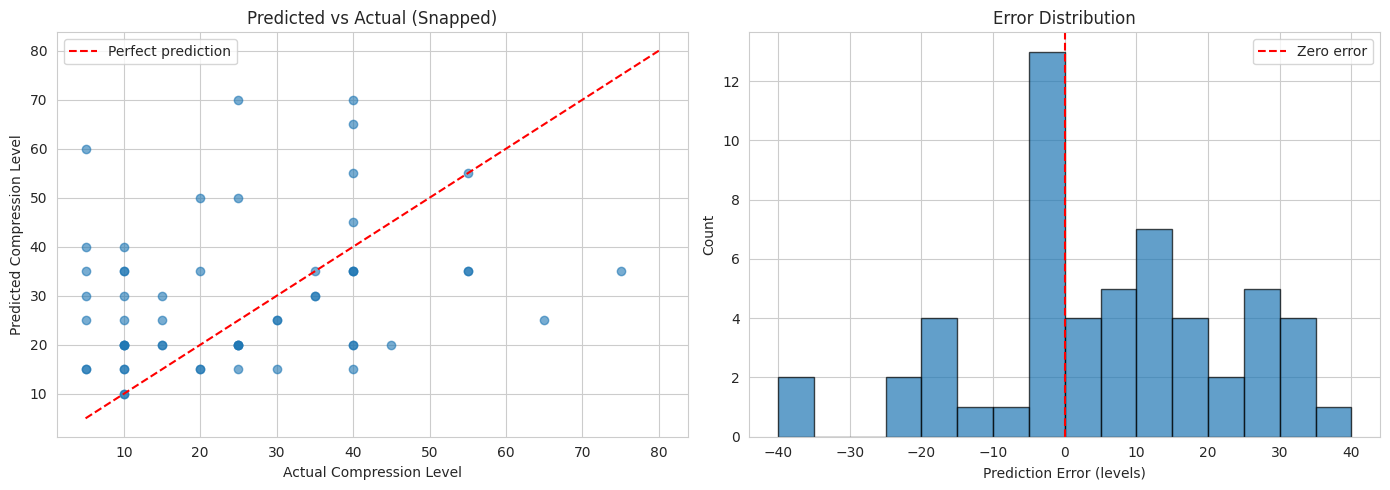

In [16]:
# Prediction vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_snapped, alpha=0.6)
axes[0].plot([5, 80], [5, 80], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Compression Level')
axes[0].set_ylabel('Predicted Compression Level')
axes[0].set_title('Predicted vs Actual (Snapped)')
axes[0].legend()

# Error distribution
errors = y_pred_snapped - y_test.values
axes[1].hist(errors, bins=np.arange(-40, 45, 5), edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error (levels)')
axes[1].set_ylabel('Count')
axes[1].set_title('Error Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Inference Example

In [17]:
def predict_optimal_compression(num_users: int, cqi: float) -> int:
    """
    Predict optimal compression level for given network conditions.
    
    Args:
        num_users: Number of users in the cell (2-10)
        cqi: Average Channel Quality Indicator (1-15)
    
    Returns:
        Optimal compression level (5, 10, 15, ..., 80)
    """
    features = np.array([[num_users, cqi]])
    raw_pred = model.predict(features)[0]
    return snap_to_compression_level(raw_pred)

# Test examples
test_cases = [
    (2, 15.0),   # Few users, excellent CQI
    (5, 14.0),   # Medium users, good CQI
    (10, 12.0),  # Many users, moderate CQI
    (3, 8.0),    # Few users, poor CQI
    (8, 10.0),   # Many users, fair CQI
]

print("Prediction Examples:")
print("-" * 50)
for num_users, cqi in test_cases:
    pred = predict_optimal_compression(num_users, cqi)
    print(f"Users: {num_users:2d}, CQI: {cqi:5.1f} -> Optimal Compression: {pred}")

Prediction Examples:
--------------------------------------------------
Users:  2, CQI:  15.0 -> Optimal Compression: 15
Users:  5, CQI:  14.0 -> Optimal Compression: 20
Users: 10, CQI:  12.0 -> Optimal Compression: 20
Users:  3, CQI:   8.0 -> Optimal Compression: 35
Users:  8, CQI:  10.0 -> Optimal Compression: 20


## 7. Save Model

In [18]:
import joblib

# Save the model
model_path = 'compression_model.joblib'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# Quick verification
loaded_model = joblib.load(model_path)
test_pred = loaded_model.predict(np.array([[5, 14.0]]))
print(f"Loaded model test prediction: {snap_to_compression_level(test_pred[0])}")

Model saved to: compression_model.joblib
Loaded model test prediction: 20


## Summary

- **Model**: XGBoost Regressor
- **Input Features**: `num_users`, `avg_cqi`
- **Target**: Optimal compression level (snapped to 5, 10, 15, ..., 80)
- **Optimal Definition**: Lowest MSE while maintaining ≥99% delay reliability
- **Output**: Discrete compression level for real-time prediction